In [296]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn import metrics

import matplotlib.pyplot as plt

### Data load
#### Data description: https://archive.ics.uci.edu/ml/datasets/wine+quality

In [183]:
url = 'https://raw.githubusercontent.com/JunetaeKim/DeepLearningClass/main/Dataset/wine.csv'
df = pd.read_csv(url, header=None)

### Data shuffling and sampling

In [184]:
df = df.sample(frac=1.0)
dataset = df.values
X = dataset[:, :12]
Y = dataset[:, 12]
X.shape, Y.shape
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=0)


### Custom Loss: CustBCE

In [185]:
def CustBCE (y_true, y_pred):
    
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1-1e-7)
    
    BCE = y_true * tf.math.log(y_pred) + (1-y_true)* tf.math.log(1-y_pred)
    BCE = tf.reduce_mean(-BCE)
    return BCE

### Model structure 

In [186]:
def WineModel ():
    
    Inp = Input(shape=(X.shape[-1]))
    Hidden1 = Dense(30, activation='relu')(Inp)
    Hidden2 = Dense(12, activation='relu')(Hidden1)
    Hidden3 = Dense(8, activation='relu')(Hidden2)
    Output = Dense(1, activation='sigmoid')(Hidden3)

    return Model(Inp, Output)


### Model save directory setting

In [234]:
save_path = './Results/'
if not os.path.exists(save_path):
    os.mkdir(save_path)


### Model save environment setting: Saving the model training result with the same name over epochs if the training performance improves. 

In [300]:
ModelSaveSameName = save_path+'WineM.hdf5'
ModelSave = ModelCheckpoint(filepath=ModelSaveSameName, monitor='val_loss', verbose=1, save_best_only=True)

### Early Stopping setting

In [301]:
EarlyStop = EarlyStopping(monitor='val_loss', patience=10)

In [319]:
Wine = WineModel()
Wine.compile(loss=CustBCE, optimizer='adam', metrics=['accuracy'])

HistWine = Wine.fit(X_train, Y_train, validation_data=(X_test,Y_test), epochs=200, batch_size=300,  verbose=1, callbacks=[ModelSave, EarlyStop])

Epoch 1/200
18/18 [==============================] - 0s 9ms/step - loss: 8.0675 - accuracy: 0.2492 - val_loss: 4.3523 - val_accuracy: 0.2415

Epoch 00001: val_loss did not improve from 0.10500
Epoch 2/200
18/18 [==============================] - 0s 5ms/step - loss: 3.1912 - accuracy: 0.2568 - val_loss: 0.6805 - val_accuracy: 0.5308

Epoch 00002: val_loss did not improve from 0.10500
Epoch 3/200
18/18 [==============================] - 0s 5ms/step - loss: 0.4785 - accuracy: 0.7952 - val_loss: 0.3274 - val_accuracy: 0.8700

Epoch 00003: val_loss did not improve from 0.10500
Epoch 4/200
18/18 [==============================] - 0s 5ms/step - loss: 0.3029 - accuracy: 0.8932 - val_loss: 0.2732 - val_accuracy: 0.8931

Epoch 00004: val_loss did not improve from 0.10500
Epoch 5/200
18/18 [==============================] - 0s 5ms/step - loss: 0.2452 - accuracy: 0.9167 - val_loss: 0.2240 - val_accuracy: 0.9215

Epoch 00005: val_loss did not improve from 0.10500
Epoch 6/200
18/18 [================

### Plot loss graphs

Text(0, 0.5, 'loss')

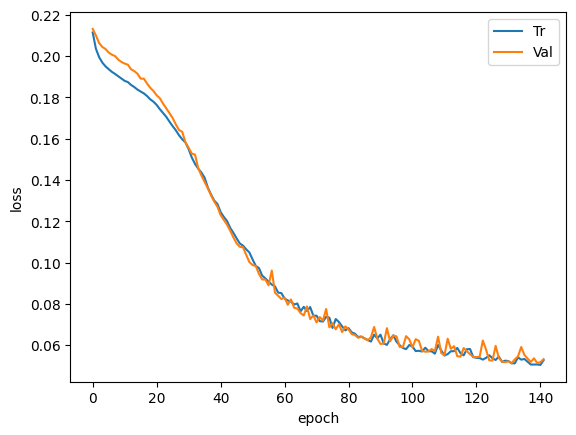

In [320]:
StartIDX = 5
plt.plot(Wine.history.history['loss'][StartIDX:], label='Tr')
plt.plot(Wine.history.history['val_loss'][StartIDX:], label='Val')
plt.legend() 
plt.xlabel('epoch')
plt.ylabel('loss')

### Set the class weight value

In [321]:
ClassRate = np.unique(Y_train, return_counts=True)[1]
WeightPara = ClassRate.max() / ClassRate.min()
ToScaleIdx = np.argmin(ClassRate)
ToScaleIdx, WeightPara

(1, 3.0443579766536963)

### Custom Loss: CustWeightBCE

In [322]:
def CustWeightBCE (y_true, y_pred):
    
    Mask_one = y_true==1
    Mask_zero =~Mask_one
    W_one = WeightPara
    W_zero = 1.
    
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1-1e-7)
    
    BCE = y_true * tf.math.log(y_pred) + (1-y_true)* tf.math.log(1-y_pred)
    BCE = tf.concat([BCE[Mask_one]*W_one, BCE[Mask_zero]*W_zero],axis=0)
    BCE = tf.reduce_mean(-BCE)
    
    return BCE



In [323]:
ModelSaveSameName = save_path+'WineWM.hdf5'
ModelSave = ModelCheckpoint(filepath=ModelSaveSameName, monitor='val_loss', verbose=1, save_best_only=True)

WineWM = WineModel()
WineWM.compile(loss=CustWeightBCE, optimizer='adam', metrics=['accuracy'])

HistWineWM =  WineWM.fit(X_train, Y_train, validation_data=(X_test,Y_test), epochs=200, batch_size=300,  verbose=1, callbacks=[ModelSave, EarlyStop])

Epoch 1/200
18/18 [==============================] - 0s 11ms/step - loss: 2.9363 - accuracy: 0.7518 - val_loss: 0.7382 - val_accuracy: 0.9023

Epoch 00001: val_loss improved from inf to 0.73823, saving model to ./Results\WineWM.hdf5
Epoch 2/200
18/18 [==============================] - 0s 5ms/step - loss: 0.7630 - accuracy: 0.8048 - val_loss: 0.6595 - val_accuracy: 0.8985

Epoch 00002: val_loss improved from 0.73823 to 0.65946, saving model to ./Results\WineWM.hdf5
Epoch 3/200
18/18 [==============================] - 0s 5ms/step - loss: 0.5723 - accuracy: 0.9281 - val_loss: 0.5389 - val_accuracy: 0.9331

Epoch 00003: val_loss improved from 0.65946 to 0.53891, saving model to ./Results\WineWM.hdf5
Epoch 4/200
18/18 [==============================] - 0s 5ms/step - loss: 0.5141 - accuracy: 0.9304 - val_loss: 0.4776 - val_accuracy: 0.9323

Epoch 00004: val_loss improved from 0.53891 to 0.47756, saving model to ./Results\WineWM.hdf5
Epoch 5/200
18/18 [==============================] - 0s 5ms

### Plot loss graphs

Text(0, 0.5, 'loss')

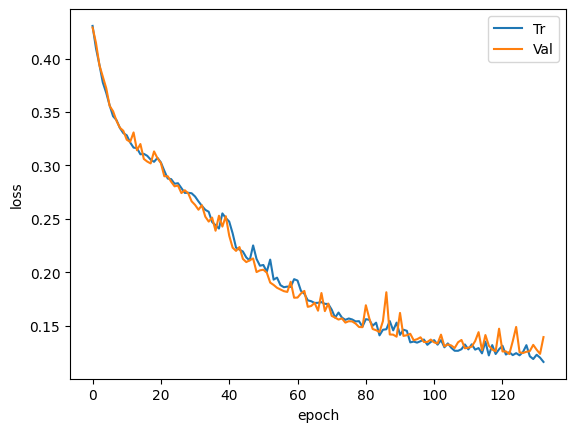

In [324]:
StartIDX = 5
plt.plot(WineWM.history.history['loss'][StartIDX:], label='Tr')
plt.plot(WineWM.history.history['val_loss'][StartIDX:], label='Val')
plt.legend() 
plt.xlabel('epoch')
plt.ylabel('loss')

### Accuracy difference between weighted and unweighted models

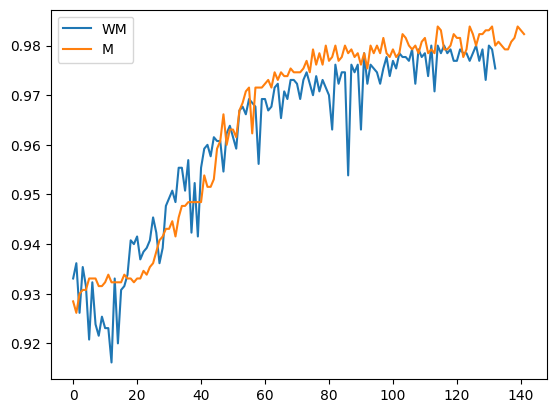

In [335]:
plt.plot(HistWineWM.history['val_accuracy'][StartIDX:],  label='WM')
plt.plot(HistWine.history['val_accuracy'][StartIDX:],  label='M')
plt.legend()

### Weighting classes using the TensorFlow class_weight function

In [342]:
ModelSaveSameName = save_path+'WineWM2.hdf5'
ModelSave = ModelCheckpoint(filepath=ModelSaveSameName, monitor='val_loss', verbose=1, save_best_only=True)

WineWM2 = WineModel()
WineWM2.compile(loss=tf.losses.binary_crossentropy, optimizer='adam', metrics=['accuracy'])

class_weight = {0: 1., 1: WeightPara}

HistWineWM2 =  WineWM2.fit(X_train, Y_train, validation_data=(X_test,Y_test), epochs=200, batch_size=300,  verbose=1, callbacks=[ModelSave, EarlyStop], class_weight=class_weight)

Epoch 1/200
18/18 [==============================] - 0s 9ms/step - loss: 4.2346 - accuracy: 0.3025 - val_loss: 0.3998 - val_accuracy: 0.7585

Epoch 00001: val_loss improved from inf to 0.39976, saving model to ./Results\WineWM2.hdf5
Epoch 2/200
18/18 [==============================] - 0s 5ms/step - loss: 0.9850 - accuracy: 0.7605 - val_loss: 0.4097 - val_accuracy: 0.7585

Epoch 00002: val_loss did not improve from 0.39976
Epoch 3/200
18/18 [==============================] - 0s 5ms/step - loss: 0.9226 - accuracy: 0.7558 - val_loss: 0.4504 - val_accuracy: 0.7585

Epoch 00003: val_loss did not improve from 0.39976
Epoch 4/200
18/18 [==============================] - 0s 5ms/step - loss: 0.9130 - accuracy: 0.7526 - val_loss: 0.4591 - val_accuracy: 0.7585

Epoch 00004: val_loss did not improve from 0.39976
Epoch 5/200
18/18 [==============================] - 0s 5ms/step - loss: 0.8933 - accuracy: 0.7549 - val_loss: 0.4355 - val_accuracy: 0.7585

Epoch 00005: val_loss did not improve from 0.3

### Accuracy difference between weighted and unweighted models

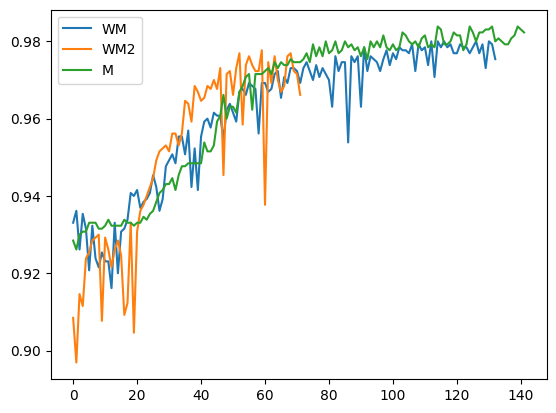

In [344]:
plt.plot(HistWineWM.history['val_accuracy'][StartIDX:],  label='WM')
plt.plot(HistWineWM2.history['val_accuracy'][StartIDX:],  label='WM2')
plt.plot(HistWine.history['val_accuracy'][StartIDX:],  label='M')
plt.legend()